In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import gym
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gymnasium as gym
from gymnasium import spaces

In [3]:
class Env_3_Drone_Delivery(gym.Env):
    def __init__(self, grid_size=6, stochastic=False, multiple_deliveries=False):
        super(Env_3_Drone_Delivery, self).__init__()

        self.grid_size = grid_size
        self.stochastic = stochastic
        self.multiple_deliveries = multiple_deliveries
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'PICKUP', 'DROPOFF']
        self.no_fly_zones = {(1, 1), (2, 3), (4, 4)}  # no-fly zones

        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),  # x position
            spaces.Discrete(self.grid_size),  # y position
            spaces.Discrete(2)                # has_package (0 or 1)
        ))

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.drone_position = (0, 0)  # Starting point at the top-left corner (Warehouse)
        self.package_picked = False
        self.delivery_target = (self.grid_size - 1, self.grid_size - 1)  # Customer location (bottom-right corner)
        self.pickup_location = (0, 0)  # Pickup location (Warehouse)
        self.steps_taken = 0
        self.total_reward = 0
        if self.multiple_deliveries:
            self.delivery_count = 0

        return self.drone_position + (self.package_picked,), {}

    def step(self, action):
        reward = -1
        new_position = list(self.drone_position[:2])

        if action == 0 and self.drone_position[0] > 0:  # UP
            new_position[0] -= 1
        elif action == 1 and self.drone_position[0] < self.grid_size - 1:  # DOWN
            new_position[0] += 1
        elif action == 2 and self.drone_position[1] > 0:  # LEFT
            new_position[1] -= 1
        elif action == 3 and self.drone_position[1] < self.grid_size - 1:  # RIGHT
            new_position[1] += 1

        if self.stochastic and random.random() < 0.1:  # 10% chance of deviation
            new_position = self._applying_stochastic_conditions(new_position)

        new_position = tuple(new_position)
        if new_position in self.no_fly_zones:
            reward = -20
        else:
            self.drone_position = new_position

        if action == 4 and self.drone_position == self.pickup_location and not self.package_picked:
            self.package_picked = True
            reward += 10  # Reward for picking up the package

        terminated = False
        if action == 5 and self.drone_position == self.delivery_target and self.package_picked:
            reward = 20
            self.package_picked = False
            if self.multiple_deliveries:
                self.delivery_count += 1
            else:
                terminated = True

        self.steps_taken += 1
        self.total_reward += reward
        truncated = self.steps_taken >= 100  # Arbitrary step limit

        return self.drone_position + (self.package_picked,), reward, terminated, truncated, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size, 3))  # RGB grid
        fig, ax = plt.subplots()
        drone_empty = mpimg.imread("drone_empty.jpg")
        drone_loaded = mpimg.imread("drone_loaded.jpg")
        warehouse = mpimg.imread("warehouse.jpg")
        customer = mpimg.imread("customer.jpg")
        no_fly_zone = mpimg.imread("no_fly_zone.jpg")
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.no_fly_zones:
                    ax.imshow(no_fly_zone, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.pickup_location:
                    ax.imshow(warehouse, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.delivery_target:
                    ax.imshow(customer, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])

        if self.package_picked:
            ax.imshow(drone_loaded, extent=[self.drone_position[1], self.drone_position[1] + 1,
                                            self.grid_size - self.drone_position[0] - 1,
                                            self.grid_size - self.drone_position[0]])
        else:
            ax.imshow(drone_empty, extent=[self.drone_position[1], self.drone_position[1] + 1,
                                        self.grid_size - self.drone_position[0] - 1,
                                        self.grid_size - self.drone_position[0]])

        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

    def _applying_stochastic_conditions(self, position):
        deviations = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        deviation = random.choice(deviations)
        new_position = (position[0] + deviation[0], position[1] + deviation[1])
        return tuple(max(0, min(self.grid_size - 1, x)) for x in new_position)


In [20]:
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)

        # Dueling DQN specific layers
        self.value_stream = nn.Linear(256, 1)
        self.advantage_stream = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        return value + (advantage - advantage.mean())

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = ReplayBuffer(30000)
        self.batch_size = 64
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DuelingDQN(state_dim, action_dim).to(self.device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

    def select_action(self, state, greedy=False):
        if not greedy and random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                return torch.argmax(self.policy_net(state)).item()

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0]
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = F.mse_loss(q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

def train_dqn(env, agent, episodes=1000, target_update=10):
    rewards_history = []
    epsilon_history = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in range(1000):  # Limit steps per episode
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            agent.update()
            if done or truncated:
                break
        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)
        agent.decay_epsilon()
        if episode % target_update == 0:
            agent.update_target_network()
        if (episode+1) % 10 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_history)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')

    plt.show()

    return rewards_history, epsilon_history


Episode 10, Total Reward: -185, Avg Reward: -199.40, Epsilon: 0.951
Episode 20, Total Reward: -214, Avg Reward: -203.55, Epsilon: 0.905
Episode 30, Total Reward: -185, Avg Reward: -185.37, Epsilon: 0.860
Episode 40, Total Reward: -128, Avg Reward: -184.57, Epsilon: 0.818
Episode 50, Total Reward: -90, Avg Reward: -173.84, Epsilon: 0.778
Episode 60, Total Reward: -166, Avg Reward: -163.15, Epsilon: 0.740
Episode 70, Total Reward: -180, Avg Reward: -158.31, Epsilon: 0.704
Episode 80, Total Reward: -58, Avg Reward: -156.24, Epsilon: 0.670
Episode 90, Total Reward: -43, Avg Reward: -146.81, Epsilon: 0.637
Episode 100, Total Reward: -25, Avg Reward: -138.18, Epsilon: 0.606
Episode 110, Total Reward: -247, Avg Reward: -127.92, Epsilon: 0.576
Episode 120, Total Reward: -20, Avg Reward: -111.66, Epsilon: 0.548
Episode 130, Total Reward: -13, Avg Reward: -103.34, Epsilon: 0.521
Episode 140, Total Reward: -48, Avg Reward: -89.19, Epsilon: 0.496
Episode 150, Total Reward: -9, Avg Reward: -81.51, 

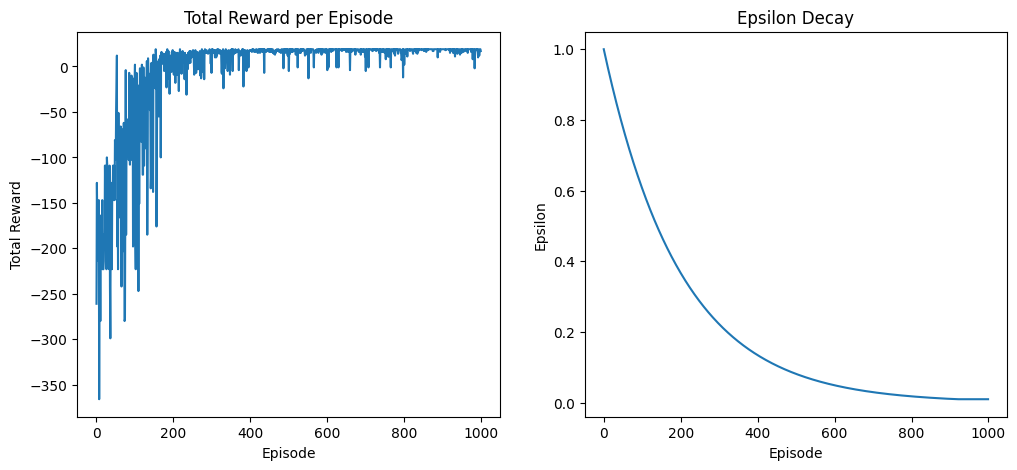

In [21]:
env = Env_3_Drone_Delivery(grid_size=6, stochastic=False, multiple_deliveries=False)
state_dim = len(env.observation_space)
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)
grid_world_rewards, grid_world_epsilon = train_dqn(env, agent, episodes=1000)
torch.save(agent.policy_net.state_dict(), "dueling_dqn_drone_delivery.pth")

Evaluation Episode 1: Total Reward = 19
Evaluation Episode 2: Total Reward = 19
Evaluation Episode 3: Total Reward = 19
Evaluation Episode 4: Total Reward = 19
Evaluation Episode 5: Total Reward = 19
Evaluation Episode 6: Total Reward = 19
Evaluation Episode 7: Total Reward = 19
Evaluation Episode 8: Total Reward = 19
Evaluation Episode 9: Total Reward = 19
Evaluation Episode 10: Total Reward = 19
Average Reward over 10 Evaluation Episodes: 19.00


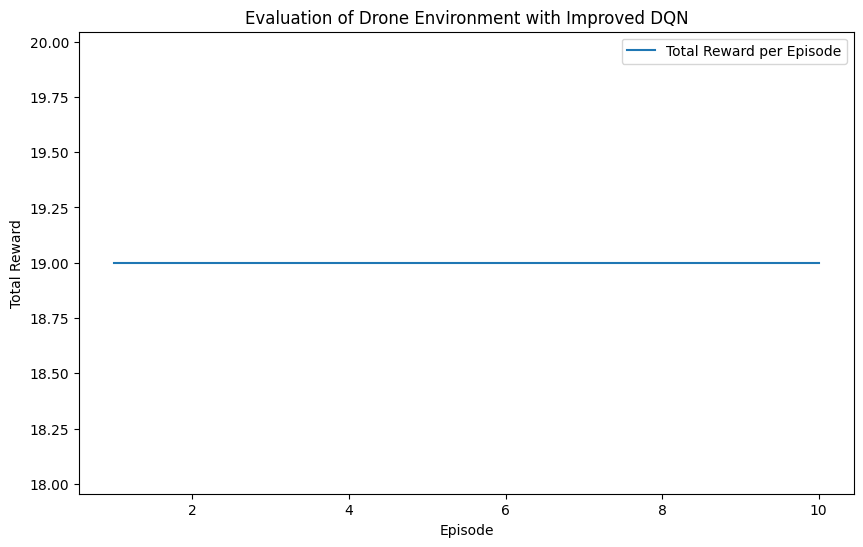

In [28]:
def evaluate_dqn(env, agent, episodes=10, name=None):
    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0

        for t in range(1000):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            state = np.array(next_state, dtype=np.float32)
            total_reward += reward
            if done or truncated:
                break
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} Evaluation Episodes: {avg_reward:.2f}")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, episodes + 1), total_rewards, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Evaluation of {name} with Improved DQN")
    plt.legend()
    plt.show()
    return total_rewards

grid_world_evaluation = evaluate_dqn(env, agent, episodes=10, name="Drone Environment")

## Cartpole-v1 Environment with Improved DQN

Episode 10, Total Reward: 36.0, Avg Reward: 24.80, Epsilon: 0.951
Episode 20, Total Reward: 13.0, Avg Reward: 25.05, Epsilon: 0.905
Episode 30, Total Reward: 14.0, Avg Reward: 24.07, Epsilon: 0.860
Episode 40, Total Reward: 14.0, Avg Reward: 24.65, Epsilon: 0.818
Episode 50, Total Reward: 68.0, Avg Reward: 27.64, Epsilon: 0.778
Episode 60, Total Reward: 59.0, Avg Reward: 28.87, Epsilon: 0.740
Episode 70, Total Reward: 92.0, Avg Reward: 31.80, Epsilon: 0.704
Episode 80, Total Reward: 63.0, Avg Reward: 35.48, Epsilon: 0.670
Episode 90, Total Reward: 14.0, Avg Reward: 35.99, Epsilon: 0.637
Episode 100, Total Reward: 40.0, Avg Reward: 36.58, Epsilon: 0.606
Episode 110, Total Reward: 93.0, Avg Reward: 39.49, Epsilon: 0.576
Episode 120, Total Reward: 23.0, Avg Reward: 44.25, Epsilon: 0.548
Episode 130, Total Reward: 110.0, Avg Reward: 47.15, Epsilon: 0.521
Episode 140, Total Reward: 22.0, Avg Reward: 52.48, Epsilon: 0.496
Episode 150, Total Reward: 17.0, Avg Reward: 56.70, Epsilon: 0.471
Epi

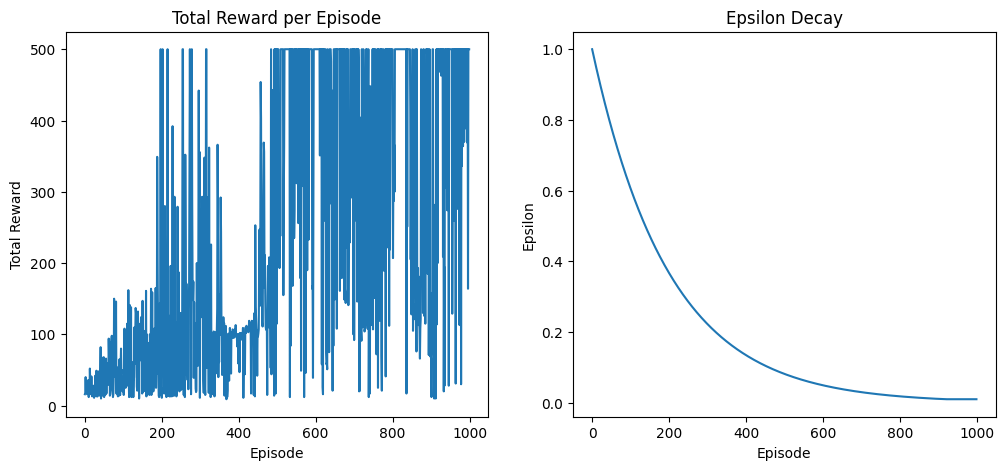

In [23]:
env1 = gym.make("CartPole-v1")
state_dim = env1.observation_space.shape[0]
action_dim = env1.action_space.n
agent1 = DQNAgent(state_dim, action_dim)
cartpole_rewards, cartpole_epsilon = train_dqn(env1, agent1, episodes=1000, target_update=5)
torch.save(agent1.policy_net.state_dict(), "dueling_dqn_cartpole.pth")

Evaluation Episode 1: Total Reward = 500.0
Evaluation Episode 2: Total Reward = 500.0
Evaluation Episode 3: Total Reward = 500.0
Evaluation Episode 4: Total Reward = 500.0
Evaluation Episode 5: Total Reward = 500.0
Evaluation Episode 6: Total Reward = 500.0
Evaluation Episode 7: Total Reward = 500.0
Evaluation Episode 8: Total Reward = 500.0
Evaluation Episode 9: Total Reward = 500.0
Evaluation Episode 10: Total Reward = 500.0
Average Reward over 10 Evaluation Episodes: 500.00


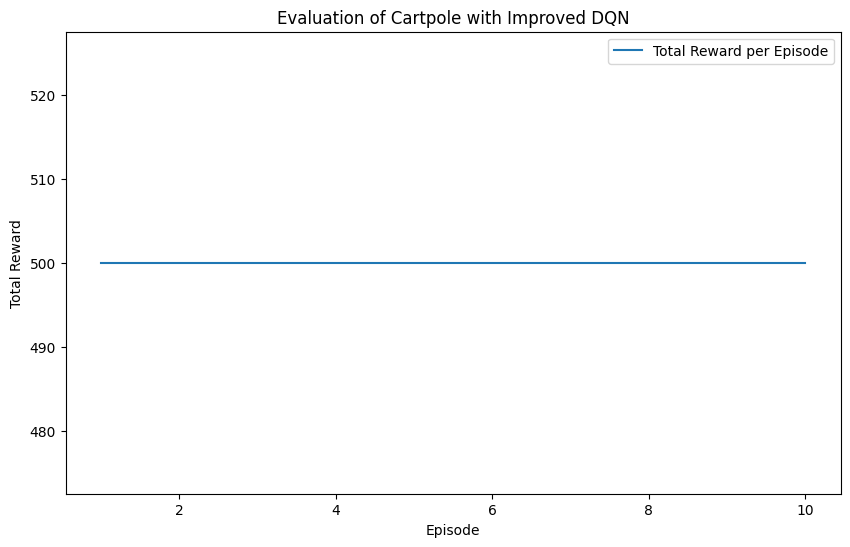

Cartpole Environment solved!


In [31]:
cartpole_evaluation = evaluate_dqn(env1, agent1, episodes=10, name="Cartpole")
if np.mean(cartpole_evaluation) >= 470:
    print("Cartpole Environment solved!")

## FrozenLake Environment with Improved DQN

Episode 10, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.951
Episode 20, Total Reward: 0.0, Avg Reward: 0.00, Epsilon: 0.905
Episode 30, Total Reward: 0.0, Avg Reward: 0.03, Epsilon: 0.860
Episode 40, Total Reward: 0.0, Avg Reward: 0.05, Epsilon: 0.818
Episode 50, Total Reward: 0.0, Avg Reward: 0.04, Epsilon: 0.778
Episode 60, Total Reward: 0.0, Avg Reward: 0.03, Epsilon: 0.740
Episode 70, Total Reward: 0.0, Avg Reward: 0.03, Epsilon: 0.704
Episode 80, Total Reward: 0.0, Avg Reward: 0.03, Epsilon: 0.670
Episode 90, Total Reward: 0.0, Avg Reward: 0.02, Epsilon: 0.637
Episode 100, Total Reward: 0.0, Avg Reward: 0.02, Epsilon: 0.606
Episode 110, Total Reward: 0.0, Avg Reward: 0.02, Epsilon: 0.576
Episode 120, Total Reward: 0.0, Avg Reward: 0.02, Epsilon: 0.548
Episode 130, Total Reward: 0.0, Avg Reward: 0.02, Epsilon: 0.521
Episode 140, Total Reward: 0.0, Avg Reward: 0.01, Epsilon: 0.496
Episode 150, Total Reward: 0.0, Avg Reward: 0.01, Epsilon: 0.471
Episode 160, Total Reward: 0.0, Av

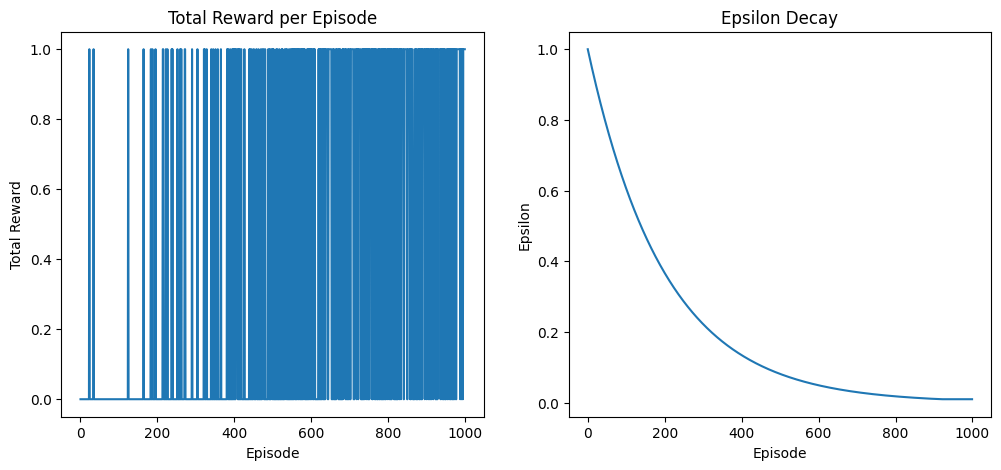

In [37]:
def train_dqn2(env, agent, episodes=1000, target_update=10):
    rewards_history = []
    epsilon_history = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = one_hot_encode(state, agent.state_dim)
        total_reward = 0

        for t in range(1000):  # Limit steps per episode
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = one_hot_encode(next_state, agent.state_dim)
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            agent.update()
            if done or truncated:
                break
        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)
        agent.decay_epsilon()
        if episode % target_update == 0:
            agent.update_target_network()
        if (episode+1) % 10 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_history)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')

    plt.show()

    return rewards_history, epsilon_history

def one_hot_encode(state, state_dim):
    one_hot = np.zeros(state_dim, dtype=np.float32)
    one_hot[state] = 1.0
    return one_hot

env2 = gym.make("FrozenLake-v1")
state_dim = env2.observation_space.n
action_dim = env2.action_space.n
agent2 = DQNAgent(state_dim, action_dim)
frozenlake_rewards, frozenlake_epsilon = train_dqn2(env2, agent2, episodes=1000)
torch.save(agent2.policy_net.state_dict(), "dueling_dqn_frozenlake.pth")

Evaluation Episode 1: Total Reward = 1.0
Evaluation Episode 2: Total Reward = 1.0
Evaluation Episode 3: Total Reward = 1.0
Evaluation Episode 4: Total Reward = 1.0
Evaluation Episode 5: Total Reward = 1.0
Average Reward over 5 Evaluation Episodes: 1.00


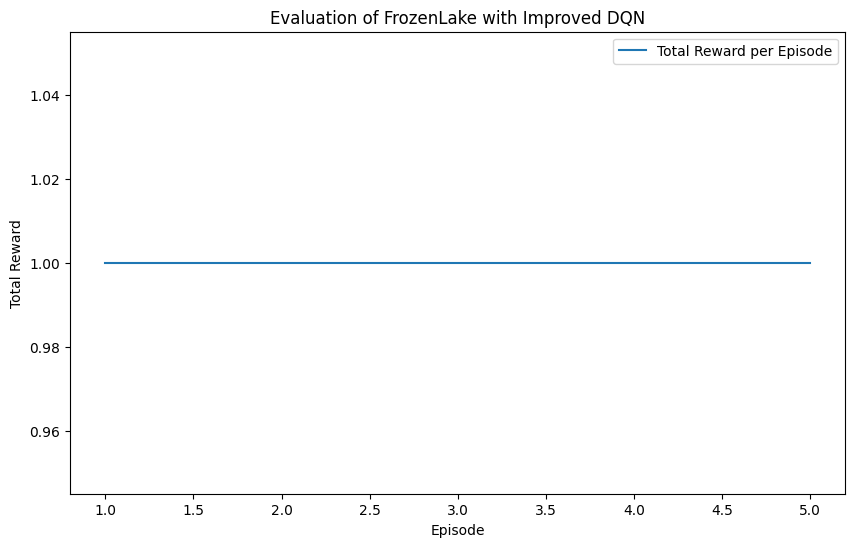

FrozenLake Environment solved!


In [45]:
def evaluate_dqn2(env, agent, episodes=10, name=None):
    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        state = one_hot_encode(state, agent.state_dim)
        total_reward = 0

        for t in range(1000):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            state = one_hot_encode(next_state, agent.state_dim)
            total_reward += reward
            if done or truncated:
                break
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} Evaluation Episodes: {avg_reward:.2f}")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, episodes + 1), total_rewards, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Evaluation of {name} with Improved DQN")
    plt.legend()
    plt.show()
    return total_rewards

frozenlake_evaluation = evaluate_dqn2(env2, agent2, episodes=5, name="FrozenLake")
if np.mean(frozenlake_evaluation) >= 0.8:
    print("FrozenLake Environment solved!")